# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Set general experiment parameters

In [4]:
MLE_N_ITER = 20000
BBVI_N_ITER = 20000
VI_FB_N_ITER = 3000
VI_N_ITER = 3000
GB_N_ITER = 300

VI_TOL = 1e-4

PRINT_EVERY = 100
PRINT_EVERY_VI = 10
CALLBACK_END = '\n'

Set random seed for all experiments

In [5]:
seed = np.random.randint(2**32-1)
gen_seed = None
sim_seed = None



---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

### V2. Larger setting

In [6]:
from experiments_utils import generate_parameters

dim = 10
max_jumps=7e3 * dim

param_dict = generate_parameters(dim=dim, seed=gen_seed)

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.05  0.03  0.03  0.01  0.02  0.03  0.02  0.04  0.01  0.05]
Alpha:
[[ 0.00  0.18  0.00  0.18  0.13  0.14  0.12  0.13  0.00  0.17]
 [ 0.13  0.00  0.13  0.00  0.00  0.11  0.00  0.00  0.18  0.00]
 [ 0.11  0.00  0.00  0.00  0.11  0.19  0.19  0.16  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.13  0.00  0.16  0.00  0.12]
 [ 0.00  0.00  0.11  0.00  0.14  0.00  0.17  0.19  0.00  0.12]
 [ 0.00  0.17  0.00  0.00  0.17  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.12  0.00  0.00  0.13  0.00  0.12  0.00  0.00  0.16]
 [ 0.14  0.00  0.00  0.12  0.00  0.18  0.00  0.12  0.00  0.00]
 [ 0.00  0.00  0.20  0.00  0.00  0.12  0.00  0.00  0.00  0.00]
 [ 0.00  0.19  0.16  0.19  0.18  0.00  0.00  0.17  0.20  0.00]]
Beta:
[[ 0.05  0.80  0.11  0.39  0.18  0.94  0.81  0.42  0.88  0.24]
 [ 0.50  0.64  0.26  0.14  0.68  0.69  0.76  0.16  0.15  0.49]
 [ 0.31  0.51  0.40  0.89  0.35  0.95  0.47  0.19  0.36  0.64]
 [ 0.32  0.21  0.14  0.16  0.95  0.68  0.72  0.95  0.74  0.21]
 [ 0.56  0.66  0.21  0.20  0.40 

### Simulate a realization

In [7]:
coeffs_true_dict = {
    'baseline': mu.numpy(),
    'adjacency': alpha.numpy(),
    'beta': beta.numpy()
}

coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=sim_seed)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 70,000 events with end time: 45202.078125
    - Events:
      - dim  0 ( 5857 events): [    66.31     71.67     80.19 ...  45169.36  45174.48  45190.67]
      - dim  1 ( 6870 events): [    50.76     56.15    111.64 ...  45167.43  45181.51  45182.12]
      - dim  2 ( 6915 events): [   115.64    121.77    125.21 ...  45192.52  45194.21  45200.74]
      - dim  3 ( 4730 events): [     7.91     98.04    120.52 ...  45167.24  45194.52  45196.43]
      - dim  4 ( 8959 events): [    54.71    131.31    131.84 ...  45187.09  45189.07  45193.11]
      - dim  5 ( 8279 events): [    17.33     17.98     71.09 ...  45190.25  45192.10  45202.08]
      - dim  6 ( 5662 events): [   135.03    135.93    143.69 ...  45177.10  45194.96  45200.58]
      - dim  7 (10705 events): [     5.61      9.96     13.69 ...  45184.52  45186.82  45198.65]
      - dim  8 ( 3617 events): [   175.37    176.77    179.58 ...  45155.62  45169.08  45172.67]
      - dim  9 ( 8406 even

---

## Test MLE

In [8]:
dim = len(events)

# set random seed
np.random.seed(seed)
torch.manual_seed(seed)

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    np.random.uniform(0.0, 1.0, size=dim),     # baseline
    np.random.uniform(0.0, 1.0, size=dim**2),  # beta
    np.random.uniform(0.0, 1.0, size=dim**2)   # adjacency
)))

# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         np.array(coeffs_true_dict['beta']).flatten(),
                         np.array(coeffs_true_dict['adjacency']).flatten()))

# Define model
model = tsvar.models.WoldModelMLE(verbose=True)
model.observe(events, end_time)

# Set callback
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    coeffs_start, print_every=PRINT_EVERY, coeffs_true=coeffs_true,
    acc_thresh=0.05, dim=dim, default_end=CALLBACK_END)

# Fit model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=0.1,
                 lr_sched=0.9999, tol=1e-4, max_iter=MLE_N_ITER,
                 penalty=tsvar.priors.GaussianPrior, C=1e10,
                 seed=None, callback=callback)
coeffs_hat = model.coeffs.detach().numpy()

iter:   100 | dx: +4.9863e-02 | loss: 3.1766e+00 | dloss: -9.12e-05 | f1-score: 0.34 | relerr: 5.36e-01 | time/it: 3.30e-02     
iter:   200 | dx: +3.4440e-02 | loss: 3.1700e+00 | dloss: -4.57e-05 | f1-score: 0.34 | relerr: 5.27e-01 | time/it: 2.80e-02     
iter:   300 | dx: +2.8639e-02 | loss: 3.1663e+00 | dloss: -3.21e-05 | f1-score: 0.34 | relerr: 5.19e-01 | time/it: 2.71e-02     
iter:   400 | dx: +2.5257e-02 | loss: 3.1634e+00 | dloss: -2.61e-05 | f1-score: 0.34 | relerr: 5.17e-01 | time/it: 2.74e-02     


KeyboardInterrupt: 

---

## Test BBVI

In [9]:
dim = len(events)
n_params = dim + dim**2 + dim**2
# set random seed
np.random.seed(seed)
torch.manual_seed(seed)
# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))
# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         np.array(coeffs_true_dict['beta']).flatten(),
                         np.array(coeffs_true_dict['adjacency']).flatten()))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim+dim**2:]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim+dim**2:],
    print_every=PRINT_EVERY,
    coeffs_true=coeffs_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end=CALLBACK_END)

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=BBVI_N_ITER,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

iter:   100 | dx: +3.9746e-02 | loss: 8.4872e+02 | dloss: +3.59e+01 | f1-score: 0.6014 | relerr: 2.70e+00 | time/it: 3.56e-02     
iter:   200 | dx: +4.8166e-02 | loss: 6.4354e+02 | dloss: -1.39e+02 | f1-score: 0.6014 | relerr: 2.36e+00 | time/it: 4.01e-02     
iter:   300 | dx: +4.0195e-02 | loss: 6.1814e+02 | dloss: -2.57e+01 | f1-score: 0.6014 | relerr: 2.21e+00 | time/it: 3.33e-02     
iter:   400 | dx: +5.1695e-02 | loss: 5.6276e+02 | dloss: -3.10e+01 | f1-score: 0.6014 | relerr: 2.15e+00 | time/it: 3.48e-02     
iter:   500 | dx: +4.7395e-02 | loss: 5.1590e+02 | dloss: +2.60e+01 | f1-score: 0.6014 | relerr: 2.12e+00 | time/it: 3.62e-02     
iter:   600 | dx: +8.6757e-02 | loss: 6.2736e+02 | dloss: +1.04e+02 | f1-score: 0.6014 | relerr: 2.24e+00 | time/it: 3.40e-02     
iter:   700 | dx: +8.2242e-02 | loss: 5.5800e+02 | dloss: -8.01e+02 | f1-score: 0.6014 | relerr: 2.31e+00 | time/it: 3.38e-02     
iter:   800 | dx: +4.1890e-02 | loss: 5.7970e+02 | dloss: +4.63e+01 | f1-score: 0.6

iter:  6400 | dx: +4.9466e-02 | loss: 1.1026e+03 | dloss: +2.77e+01 | f1-score: 0.8675 | relerr: 3.35e-01 | time/it: 4.49e-02     
iter:  6500 | dx: +1.8695e-02 | loss: 1.1026e+03 | dloss: -2.82e+00 | f1-score: 0.8675 | relerr: 3.21e-01 | time/it: 5.50e-02     
iter:  6600 | dx: +1.7117e-02 | loss: 1.1209e+03 | dloss: +1.04e+00 | f1-score: 0.8675 | relerr: 3.13e-01 | time/it: 4.97e-02     
iter:  6700 | dx: +3.1088e-02 | loss: 1.1119e+03 | dloss: -2.07e+01 | f1-score: 0.8675 | relerr: 3.09e-01 | time/it: 3.86e-02     
iter:  6800 | dx: +3.2569e-02 | loss: 1.1557e+03 | dloss: -1.29e+01 | f1-score: 0.8675 | relerr: 2.99e-01 | time/it: 3.94e-02     
iter:  6900 | dx: +2.5613e-02 | loss: 1.1797e+03 | dloss: +1.27e+01 | f1-score: 0.8675 | relerr: 3.02e-01 | time/it: 5.52e-02     
iter:  7000 | dx: +1.5984e-02 | loss: 1.1761e+03 | dloss: +1.29e+01 | f1-score: 0.8675 | relerr: 3.01e-01 | time/it: 3.94e-02     
iter:  7100 | dx: +4.0324e-02 | loss: 1.1809e+03 | dloss: -4.04e+01 | f1-score: 0.8

KeyboardInterrupt: 

---

## Test VI-fb

Algorithm: Mean-Field VI with fixed $\{\beta\}$s using `WoldModelVariationalFixedBeta`

In [8]:
dim = len(events)
# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         coeffs_true_dict['adjacency'].flatten()))
# Set model
model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
model.observe(events, beta=coeffs_true_dict['beta'])
# Set priors
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=PRINT_EVERY_VI,
    coeffs_true=coeffs_true_dict['adjacency'].flatten(),
    acc_thresh=0.05, dim=dim, default_end=CALLBACK_END)
# Fit model
conv = model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=VI_FB_N_ITER,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

iter:    10 | dx: +7.5197e-03 | f1-score: 0.83 | relerr: 3.44e-01 | time/it: 5.17e-01     
iter:    20 | dx: +3.6251e-03 | f1-score: 0.92 | relerr: 2.28e-01 | time/it: 2.87e-02     
iter:    30 | dx: +1.8342e-03 | f1-score: 0.97 | relerr: 1.66e-01 | time/it: 3.25e-02     
iter:    40 | dx: +9.8419e-04 | f1-score: 0.99 | relerr: 1.33e-01 | time/it: 2.52e-02     
iter:    50 | dx: +6.1220e-04 | f1-score: 0.99 | relerr: 1.15e-01 | time/it: 2.33e-02     
iter:    60 | dx: +4.5139e-04 | f1-score: 1.00 | relerr: 1.04e-01 | time/it: 2.38e-02     
iter:    70 | dx: +3.1352e-04 | f1-score: 1.00 | relerr: 9.66e-02 | time/it: 2.83e-02     
iter:    80 | dx: +2.5958e-04 | f1-score: 1.00 | relerr: 9.04e-02 | time/it: 2.44e-02     
iter:    90 | dx: +2.0126e-04 | f1-score: 1.00 | relerr: 8.54e-02 | time/it: 2.20e-02     
iter:   100 | dx: +1.7109e-04 | f1-score: 1.00 | relerr: 8.14e-02 | time/it: 2.16e-02     
iter:   110 | dx: +1.5961e-04 | f1-score: 1.00 | relerr: 7.80e-02 | time/it: 2.19e-02     

iter:   920 | dx: +3.6320e-05 | f1-score: 1.00 | relerr: 4.34e-02 | time/it: 4.92e-02     
iter:   930 | dx: +2.3011e-05 | f1-score: 1.00 | relerr: 4.34e-02 | time/it: 4.22e-02     
iter:   940 | dx: +3.8029e-05 | f1-score: 1.00 | relerr: 4.34e-02 | time/it: 2.86e-02     
iter:   950 | dx: +3.8684e-05 | f1-score: 1.00 | relerr: 4.33e-02 | time/it: 3.14e-02     
iter:   960 | dx: +4.0579e-05 | f1-score: 1.00 | relerr: 4.33e-02 | time/it: 2.88e-02     
iter:   970 | dx: +3.7531e-05 | f1-score: 1.00 | relerr: 4.33e-02 | time/it: 2.53e-02     
iter:   980 | dx: +3.1969e-05 | f1-score: 1.00 | relerr: 4.33e-02 | time/it: 2.43e-02     
iter:   990 | dx: +4.0455e-05 | f1-score: 1.00 | relerr: 4.32e-02 | time/it: 2.50e-02     
iter:  1000 | dx: +3.4362e-05 | f1-score: 1.00 | relerr: 4.32e-02 | time/it: 2.68e-02     
iter:  1010 | dx: +3.9955e-05 | f1-score: 1.00 | relerr: 4.32e-02 | time/it: 2.22e-02     
iter:  1020 | dx: +2.4427e-05 | f1-score: 1.00 | relerr: 4.32e-02 | time/it: 2.21e-02     

In [11]:
print('\n', '='*40, type(model).__name__, '='*40, '\n')

alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adj_true = alpha.numpy()
adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adjacency_hat)

THRESH = 0.05
fp = tsvar.utils.metrics.false_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fn = tsvar.utils.metrics.false_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tp = tsvar.utils.metrics.true_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tn = tsvar.utils.metrics.true_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('F1-Score:', fscore)
print()

print('Beta:')
print('-----')
print(' -- IS FIXED --')


 ======================================== WoldModelVariationalFixedBeta ======================================== 

Baseline:
---------
Ground truth:
[ 0.05  0.03  0.03  0.01  0.01  0.03  0.02  0.04  0.01  0.05]
Estimated:
[ 0.04  0.03  0.03  0.00  0.01  0.02  0.02  0.05  0.01  0.05]

Adjacency:
---------
Ground truth:
[[ 0.00  0.18  0.00  0.18  0.13  0.14  0.12  0.13  0.00  0.17]
 [ 0.13  0.00  0.13  0.00  0.00  0.11  0.00  0.00  0.18  0.00]
 [ 0.11  0.00  0.00  0.00  0.11  0.19  0.19  0.16  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.13  0.00  0.16  0.00  0.12]
 [ 0.00  0.00  0.11  0.00  0.14  0.00  0.17  0.19  0.00  0.12]
 [ 0.00  0.17  0.00  0.00  0.17  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.12  0.00  0.00  0.13  0.00  0.12  0.00  0.00  0.16]
 [ 0.14  0.00  0.00  0.12  0.00  0.18  0.00  0.12  0.00  0.00]
 [ 0.00  0.00  0.20  0.00  0.00  0.12  0.00  0.00  0.00  0.00]
 [ 0.00  0.19  0.16  0.19  0.18  0.00  0.00  0.17  0.20  0.00]]
Estimated:
[[ 0.00  0.18  0.00  0.19  0.14  0.16

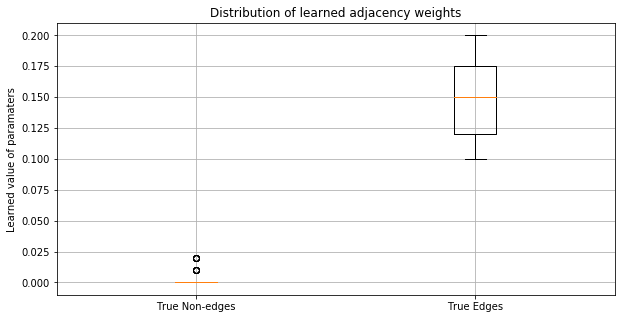

In [12]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adjacency_hat[adj_true == 0.0], 
        adjacency_hat[adj_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

---

## Test VI

Algorithm: Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Define the parameters of the prior.

---

## Test BG

In [86]:
import gb
import time

dim = len(events)

# Set random seed
np.random.seed(seed)

GB_N_ITER = 300

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=GB_N_ITER,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=1,
)
start_time = time.time()
granger_model.fit(events)
run_time = time.time() - start_time

# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

In [87]:
adj_true = alpha.numpy()
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adj_hat)
print()
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(adjacency_hat.flatten(), adj_true.flatten())
print(f'F1-Score: {fscore:.4f}')
print(f'Rel. Err: {relerr:.2e}')
print()
print('Diff with last call:')
print('sum:', np.sum(np.abs(adj_hat - last_adj)))
print('max:', np.max(np.abs(adj_hat - last_adj)))
print('# diff edges:', np.sum((adj_hat > 0.05) ^ (last_adj > 0.05)))

Adjacency:
---------
Ground truth:
[[ 0.00  0.18  0.00  0.18  0.13  0.14  0.12  0.13  0.00  0.17]
 [ 0.13  0.00  0.13  0.00  0.00  0.11  0.00  0.00  0.18  0.00]
 [ 0.11  0.00  0.00  0.00  0.11  0.19  0.19  0.16  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.13  0.00  0.16  0.00  0.12]
 [ 0.00  0.00  0.11  0.00  0.14  0.00  0.17  0.19  0.00  0.12]
 [ 0.00  0.17  0.00  0.00  0.17  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.12  0.00  0.00  0.13  0.00  0.12  0.00  0.00  0.16]
 [ 0.14  0.00  0.00  0.12  0.00  0.18  0.00  0.12  0.00  0.00]
 [ 0.00  0.00  0.20  0.00  0.00  0.12  0.00  0.00  0.00  0.00]
 [ 0.00  0.19  0.16  0.19  0.18  0.00  0.00  0.17  0.20  0.00]]
Estimated:
[[ 0.18  0.17  0.00  0.17  0.09  0.00  0.12  0.00  0.00  0.21]
 [ 0.20  0.37  0.12  0.00  0.04  0.05  0.00  0.01  0.27  0.00]
 [ 0.19  0.02  0.22  0.00  0.05  0.05  0.28  0.14  0.00  0.03]
 [ 0.00  0.00  0.01  0.31  0.00  0.16  0.00  0.18  0.00  0.16]
 [ 0.00  0.00  0.13  0.00  0.54  0.00  0.07  0.24  0.00  0.03]
 [ 0.01 

In [88]:
last_adj = adj_hat.copy()